# 1: Сортировка фото кошек и собак с помощью нейронной сети

Подгружаем нужные библиотеки

In [41]:
# Импорт библиотеки TensorFlow под псевдонимом tf
import tensorflow as tf  
# Импорт модуля ImageDataGenerator для аугментации изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator  
# Импорт класса Model для создания модели нейронной сети
from tensorflow.keras.models import Model  
# Импорт слоев для построения нейронной сети
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
# Импорт предварительно обученной модели MobileNet и функции для предварительной 
# обработки входных данных  
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input  
# Импорт модуля для предварительной обработки изображений
from tensorflow.keras.preprocessing import image  
# Импорт модуля для математических операций
import math  
# Импорт библиотеки Matplotlib для визуализации данных
import matplotlib.pyplot as plt  
# Импорт библиотеки NumPy для работы с массивами
import numpy as np
# Импорт модуля Image из библиотеки Pillow для работы с изображениями  
from PIL import Image


**Скачиваем файлы:** https://disk.yandex.ru/d/OYYCfSzhfRcw8w \
Файлы уже отсортированы по папкам: \
– в папке ${\bf train}$ файлы для обучения нейросети \
– в папке ${\bf test}$ файлы для проверки нейросети \
Внутри этих папок есть папки ${\bf cats}$ и ${\bf dogs}$, где собрано несколько десятков фотографий с кошками и собаками. \
 \
${\bf Ответьте~на~вопрос:~для~чего~нужны~константы,~которые~вводятся~ниже?}$

In [42]:
TRAIN_DATA_DIR = '/Users/nikitamakarov/Documents/321/CatsDogs/train'  # Путь к каталогу с обучающими данными
VALIDATION_DATA_DIR = '/Users/nikitamakarov/Documents/321/CatsDogs/test'  # Путь к каталогу с данными для валидации
TRAIN_SAMPLES = 1000  # Общее количество обучающих примеров
VALIDATION_SAMPLES = 200  # Общее количество примеров для валидации
NUM_CLASSES = 2  # Количество классов (в данном случае два класса: 'кошки' и 'собаки')
IMG_WIDTH, IMG_HEIGHT = 224, 224  # Размеры изображений (ширина и высота)
BATCH_SIZE = 5  # Размер пакета для обучения модели (количество образцов, обрабатываемых моделью за один шаг обучения)


Создаются два генератора данных. Для обучения нейросети недостаточно пары сотен фотографий. \
Поэтому будет использоваться такой приём как ${\bf аргументация}$ (что это?)

In [43]:
train_datagen = ImageDataGenerator(  # Создание генератора данных для обучения
    preprocessing_function=preprocess_input,  # Предварительная обработка изображений (в данном случае с использованием функции preprocess_input)
    rotation_range=20,  # Диапазон вращения изображений (от -20 до 20 градусов)
    width_shift_range=0.2,  # Диапазон сдвига изображений по горизонтали (относительно ширины изображения)
    height_shift_range=0.2,  # Диапазон сдвига изображений по вертикали (относительно высоты изображения)
    zoom_range=0.2  # Диапазон масштабирования изображений (от 0.8 до 1.2)
)

val_datagen = ImageDataGenerator(  # Создание генератора данных для валидации
    preprocessing_function=preprocess_input  # Предварительная обработка изображений (в данном случае с использованием функции preprocess_input)
)


In [44]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,  # Путь к каталогу с обучающими данными
    target_size=(IMG_WIDTH, IMG_HEIGHT),  # Желаемый размер изображений (ширина, высота)
    batch_size=BATCH_SIZE,  # Размер пакета для обучения модели
    shuffle=True,  # Перемешивание данных после каждой эпохи
    seed=12345,  # Задание начального состояния для генератора случайных чисел (для воспроизводимости)
    class_mode='categorical'  # Режим классификации (в данном случае многоклассовая классификация)
)

validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,  # Путь к каталогу с данными для валидации
    target_size=(IMG_WIDTH, IMG_HEIGHT),  # Желаемый размер изображений (ширина, высота)
    batch_size=BATCH_SIZE,  # Размер пакета для валидации модели
    shuffle=False,  # Не перемешивать данные (для сохранения порядка)
    class_mode='categorical'  # Режим классификации (в данном случае многоклассовая классификация)
)


Found 599 images belonging to 2 classes.
Found 151 images belonging to 2 classes.


# Создание модели на основе нейронной сети, которая основана на готовой нейронной сети MobileNet (она называется базовой моделью). 
В базовой модели нужно отключить обучение (для всех слоев устанавливается **trainable = False**). \
Входное изображение поступает на вход базовой модели. \
После базовой модели добавляется несколько своих слоев: \
– слой пулинга **GlobalAveragePooling2D**; \
– полносвязный слой из **16 нейронов Dense**; \
– используется механизм Дропаут (случайное отключение нейронных связей во время обучения); \
– последний слой должен выдавать два значения (вероятности того, что на фото кошка или собака – два класса). \
Таким образом мы решаем задачу двухклассовой классификации.

In [45]:
def model_maker():
    # Создание базовой модели MobileNet без верхнего слоя классификации,
    # указывается форма входных данных (ширина, высота, количество каналов)
    base_model = MobileNet(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    
    # Замораживаем веса всех слоев базовой модели, чтобы они не обучались
    for layer in base_model.layers[:]:
        layer.trainable = False
    
    # Определение входного тензора модели
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    
    # Пропуск данных через базовую модель
    custom_model = base_model(input)
    
    # Глобальное пулингование для уменьшения размерности признаков
    custom_model = GlobalAveragePooling2D()(custom_model)
    
    # Полносвязный слой с 16 нейронами и функцией активации ReLU
    custom_model = Dense(32, activation='relu')(custom_model)
    
    # Слой регуляризации для предотвращения переобучения
    custom_model = Dropout(0.25)(custom_model)
    
    # Выходной слой с NUM_CLASSES нейронами и функцией активации softmax для многоклассовой классификации
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    
    # Создание модели с заданными входом и выходом
    return Model(inputs=input, outputs=predictions)


Компилируем и обучаем модель.

In [46]:
model = model_maker()  # Создание модели нейронной сети с помощью функции model_maker()

model.compile(loss='categorical_crossentropy',  # Функция потерь - категориальная перекрестная энтропия
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Оптимизатор - Adam с коэффициентом скорости обучения 0.001
              metrics=['acc'])  # Метрика для оценки производительности модели - точность классификации

num_steps = math.ceil(float(TRAIN_SAMPLES) / BATCH_SIZE)  # Вычисление количества шагов обучения

history = model.fit(train_generator,  # Обучение модели на обучающих данных
                steps_per_epoch=num_steps,  # Количество шагов обучения
                epochs=50,  # Количество эпох обучения
                validation_data=validation_generator,  # Данные для валидации модели
                validation_steps=num_steps)  # Количество шагов валидации

Epoch 1/50
120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.8414 - loss: 0.3952

2024-05-22 12:16:37.139709: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - acc: 0.8595 - loss: 0.3498 - val_acc: 0.9272 - val_loss: 0.1341
Epoch 2/50


2024-05-22 12:16:38.509942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9437 - loss: 0.1425

2024-05-22 12:16:45.291734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9449 - loss: 0.1377 - val_acc: 0.9735 - val_loss: 0.0779
Epoch 3/50


2024-05-22 12:16:46.451547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9753 - loss: 0.0809

2024-05-22 12:16:53.264734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9751 - loss: 0.0835 - val_acc: 0.9338 - val_loss: 0.1314
Epoch 4/50


2024-05-22 12:16:54.431214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9626 - loss: 0.1127

2024-05-22 12:17:01.199113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9663 - loss: 0.1001 - val_acc: 0.9536 - val_loss: 0.0918
Epoch 5/50


2024-05-22 12:17:02.352026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9650 - loss: 0.0854

2024-05-22 12:17:09.177885: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9609 - loss: 0.0926 - val_acc: 0.9669 - val_loss: 0.0629
Epoch 6/50


2024-05-22 12:17:10.348081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9539 - loss: 0.1050

2024-05-22 12:17:17.187563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9577 - loss: 0.0980 - val_acc: 0.9536 - val_loss: 0.0850
Epoch 7/50


2024-05-22 12:17:18.357429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9777 - loss: 0.0637

2024-05-22 12:17:25.161470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9800 - loss: 0.0610 - val_acc: 0.9470 - val_loss: 0.1031
Epoch 8/50


2024-05-22 12:17:26.320682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9967 - loss: 0.0282

2024-05-22 12:17:33.122572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - acc: 0.9954 - loss: 0.0281 - val_acc: 0.9470 - val_loss: 0.1738
Epoch 9/50


2024-05-22 12:17:34.281337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9921 - loss: 0.0373

2024-05-22 12:17:41.059125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9913 - loss: 0.0368 - val_acc: 0.9603 - val_loss: 0.1092
Epoch 10/50


2024-05-22 12:17:42.223754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9757 - loss: 0.0595

2024-05-22 12:17:49.030303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9747 - loss: 0.0600 - val_acc: 0.9404 - val_loss: 0.1832
Epoch 11/50


2024-05-22 12:17:50.191932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9919 - loss: 0.0281

2024-05-22 12:17:56.989756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9871 - loss: 0.0330 - val_acc: 0.9404 - val_loss: 0.1634
Epoch 12/50


2024-05-22 12:17:58.150738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9882 - loss: 0.0389

2024-05-22 12:18:04.922939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9863 - loss: 0.0428 - val_acc: 0.9470 - val_loss: 0.0963
Epoch 13/50


2024-05-22 12:18:06.078686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - acc: 0.9898 - loss: 0.0252

2024-05-22 12:18:12.845248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - acc: 0.9899 - loss: 0.0243 - val_acc: 0.9669 - val_loss: 0.0821
Epoch 14/50


2024-05-22 12:18:13.944837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9811 - loss: 0.0529

2024-05-22 12:18:20.730523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - acc: 0.9793 - loss: 0.0542 - val_acc: 0.9669 - val_loss: 0.1050
Epoch 15/50


2024-05-22 12:18:21.862510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9745 - loss: 0.0675

2024-05-22 12:18:28.676739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9767 - loss: 0.0638 - val_acc: 0.9470 - val_loss: 0.1990
Epoch 16/50


2024-05-22 12:18:29.839376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9817 - loss: 0.0379

2024-05-22 12:18:36.630120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9803 - loss: 0.0420 - val_acc: 0.9603 - val_loss: 0.1158
Epoch 17/50


2024-05-22 12:18:37.771496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9922 - loss: 0.0361

2024-05-22 12:18:44.604348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9900 - loss: 0.0391 - val_acc: 0.9603 - val_loss: 0.0802
Epoch 18/50


2024-05-22 12:18:45.745194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9865 - loss: 0.0293

2024-05-22 12:18:52.543895: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9865 - loss: 0.0283 - val_acc: 0.9404 - val_loss: 0.1488
Epoch 19/50


2024-05-22 12:18:53.724793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9934 - loss: 0.0200

2024-05-22 12:19:00.519160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9934 - loss: 0.0238 - val_acc: 0.9470 - val_loss: 0.1444
Epoch 20/50


2024-05-22 12:19:01.687940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9935 - loss: 0.0206

2024-05-22 12:19:08.504126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9941 - loss: 0.0200 - val_acc: 0.9536 - val_loss: 0.1217
Epoch 21/50


2024-05-22 12:19:09.661148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9820 - loss: 0.0267

2024-05-22 12:19:16.423937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9839 - loss: 0.0258 - val_acc: 0.9205 - val_loss: 0.2402
Epoch 22/50


2024-05-22 12:19:17.605007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9854 - loss: 0.0368

2024-05-22 12:19:24.397621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9866 - loss: 0.0343 - val_acc: 0.9669 - val_loss: 0.0884
Epoch 23/50


2024-05-22 12:19:25.546323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9931 - loss: 0.0179

2024-05-22 12:19:32.369337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - acc: 0.9932 - loss: 0.0182 - val_acc: 0.9603 - val_loss: 0.1153
Epoch 24/50


2024-05-22 12:19:33.544406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9834 - loss: 0.0320

2024-05-22 12:19:40.360046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9847 - loss: 0.0321 - val_acc: 0.9404 - val_loss: 0.1571
Epoch 25/50


2024-05-22 12:19:41.516217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9912 - loss: 0.0200

2024-05-22 12:19:48.306226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9887 - loss: 0.0236 - val_acc: 0.9669 - val_loss: 0.0859
Epoch 26/50


2024-05-22 12:19:49.445079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9850 - loss: 0.0340

2024-05-22 12:19:56.238432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9870 - loss: 0.0313 - val_acc: 0.9404 - val_loss: 0.2264
Epoch 27/50


2024-05-22 12:19:57.420550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9956 - loss: 0.0131

2024-05-22 12:20:04.266589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9947 - loss: 0.0179 - val_acc: 0.9536 - val_loss: 0.1354
Epoch 28/50


2024-05-22 12:20:05.397828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9933 - loss: 0.0163

2024-05-22 12:20:12.229452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9913 - loss: 0.0232 - val_acc: 0.9404 - val_loss: 0.1675
Epoch 29/50


2024-05-22 12:20:13.374617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9915 - loss: 0.0277

2024-05-22 12:20:20.246400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9922 - loss: 0.0258 - val_acc: 0.9470 - val_loss: 0.1446
Epoch 30/50


2024-05-22 12:20:21.423682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9843 - loss: 0.0345

2024-05-22 12:20:28.239377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9833 - loss: 0.0362 - val_acc: 0.9536 - val_loss: 0.1679
Epoch 31/50


2024-05-22 12:20:29.419694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9938 - loss: 0.0156

2024-05-22 12:20:36.259106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - acc: 0.9922 - loss: 0.0189 - val_acc: 0.9801 - val_loss: 0.0881
Epoch 32/50


2024-05-22 12:20:37.362808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - acc: 0.9848 - loss: 0.0535

2024-05-22 12:20:44.156131: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - acc: 0.9855 - loss: 0.0508 - val_acc: 0.9669 - val_loss: 0.0697
Epoch 33/50


2024-05-22 12:20:45.325605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9843 - loss: 0.0419

2024-05-22 12:20:52.170539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9859 - loss: 0.0369 - val_acc: 0.9272 - val_loss: 0.2273
Epoch 34/50


2024-05-22 12:20:53.339445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9818 - loss: 0.0325

2024-05-22 12:21:00.174635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9858 - loss: 0.0259 - val_acc: 0.9603 - val_loss: 0.1106
Epoch 35/50


2024-05-22 12:21:01.346056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 1.0000 - loss: 0.0070

2024-05-22 12:21:08.213160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 1.0000 - loss: 0.0067 - val_acc: 0.9603 - val_loss: 0.1162
Epoch 36/50


2024-05-22 12:21:09.363945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9926 - loss: 0.0113

2024-05-22 12:21:16.200765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9922 - loss: 0.0117 - val_acc: 0.9338 - val_loss: 0.2245
Epoch 37/50


2024-05-22 12:21:17.375841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9901 - loss: 0.0165

2024-05-22 12:21:24.209459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9914 - loss: 0.0168 - val_acc: 0.9536 - val_loss: 0.1577
Epoch 38/50


2024-05-22 12:21:25.376265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9829 - loss: 0.0393

2024-05-22 12:21:32.214835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9811 - loss: 0.0422 - val_acc: 0.9603 - val_loss: 0.1716
Epoch 39/50


2024-05-22 12:21:33.371882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9933 - loss: 0.0102

2024-05-22 12:21:40.233627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9926 - loss: 0.0117 - val_acc: 0.9603 - val_loss: 0.1533
Epoch 40/50


2024-05-22 12:21:41.400212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - acc: 0.9984 - loss: 0.0068

2024-05-22 12:21:48.215303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - acc: 0.9984 - loss: 0.0074 - val_acc: 0.9669 - val_loss: 0.1728
Epoch 41/50


2024-05-22 12:21:49.376555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9906 - loss: 0.0278

2024-05-22 12:21:56.216134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9910 - loss: 0.0284 - val_acc: 0.9536 - val_loss: 0.1174
Epoch 42/50


2024-05-22 12:21:57.388874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9990 - loss: 0.0065

2024-05-22 12:22:04.215145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9988 - loss: 0.0066 - val_acc: 0.9470 - val_loss: 0.1792
Epoch 43/50


2024-05-22 12:22:05.352449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9924 - loss: 0.0146

2024-05-22 12:22:12.155235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9928 - loss: 0.0143 - val_acc: 0.9205 - val_loss: 0.3992
Epoch 44/50


2024-05-22 12:22:13.316954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9986 - loss: 0.0084

2024-05-22 12:22:20.119481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9985 - loss: 0.0069 - val_acc: 0.9603 - val_loss: 0.2178
Epoch 45/50


2024-05-22 12:22:21.263559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9924 - loss: 0.0308

2024-05-22 12:22:28.081401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9915 - loss: 0.0340 - val_acc: 0.9404 - val_loss: 0.1719
Epoch 46/50


2024-05-22 12:22:29.252142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.9982 - loss: 0.0087

2024-05-22 12:22:36.047369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - acc: 0.9976 - loss: 0.0099 - val_acc: 0.9404 - val_loss: 0.2552
Epoch 47/50


2024-05-22 12:22:37.218837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9932 - loss: 0.0134

2024-05-22 12:22:44.009140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9932 - loss: 0.0145 - val_acc: 0.9735 - val_loss: 0.0709
Epoch 48/50


2024-05-22 12:22:45.187832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9862 - loss: 0.0214

2024-05-22 12:22:51.982021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9884 - loss: 0.0194 - val_acc: 0.9404 - val_loss: 0.1670
Epoch 49/50


2024-05-22 12:22:53.143116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


119/200 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - acc: 0.9846 - loss: 0.0278

2024-05-22 12:23:00.012540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - acc: 0.9875 - loss: 0.0250 - val_acc: 0.9536 - val_loss: 0.1575
Epoch 50/50


2024-05-22 12:23:01.203558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


120/200 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - acc: 0.9898 - loss: 0.0220

2024-05-22 12:23:08.045140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9892 - loss: 0.0224 - val_acc: 0.9801 - val_loss: 0.0724


2024-05-22 12:23:09.227954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Построим график.

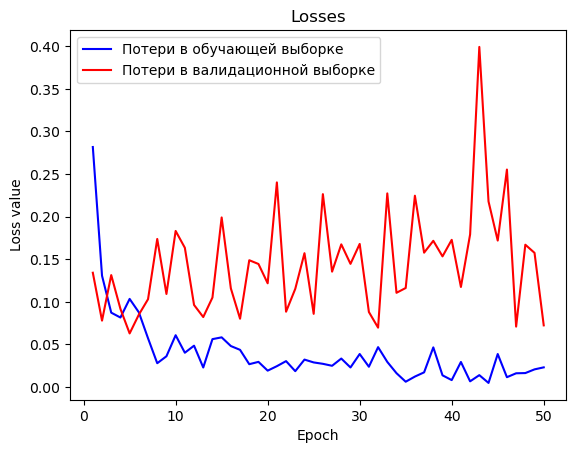

In [47]:
loss_function = history.history['loss']  # Получение значений функции потерь на обучающем наборе данных из истории обучения
val_loss_function = history.history['val_loss']  # Получение значений функции потерь на валидационном наборе данных из истории обучения
epochs = range(1, len(loss_function) + 1)  # Создание списка эпох для оси x

plt.title('Losses')  # Заголовок графика
plt.plot(epochs, loss_function, color='blue', label='Потери в обучающей выборке')  # График функции потерь на обучающем наборе
plt.plot(epochs, val_loss_function, color='red', label='Потери в валидационной выборке')  # График функции потерь на валидационном наборе
plt.xlabel('Epoch')  # Подпись оси x
plt.ylabel('Loss value')  # Подпись оси y
plt.legend()  # Добавление легенды
plt.show()  # Отображение графика




Визуализация функции потерь позволяет оценить эффективность обучения модели: мы стремимся к тому, чтобы функция потерь на обучающем и валидационном наборах данных уменьшалась с каждой эпохой, что свидетельствует о том, что модель обучается эффективно и не переобучается. \
Теперь модель можно использовать и проверить, как она работает.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


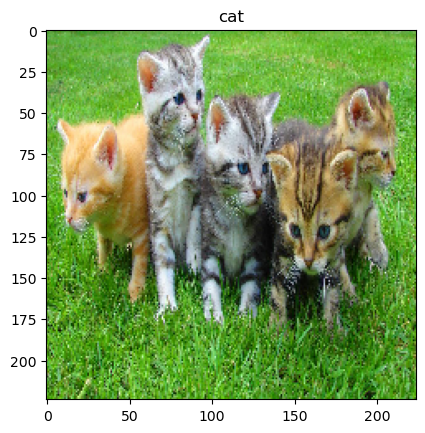

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


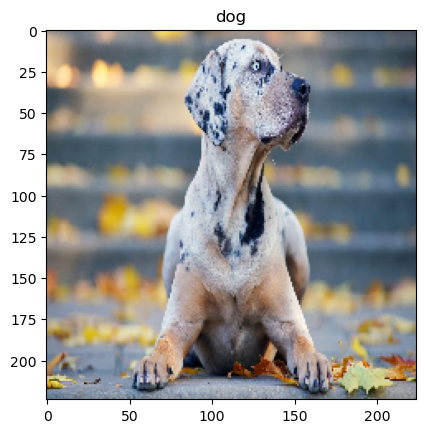

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


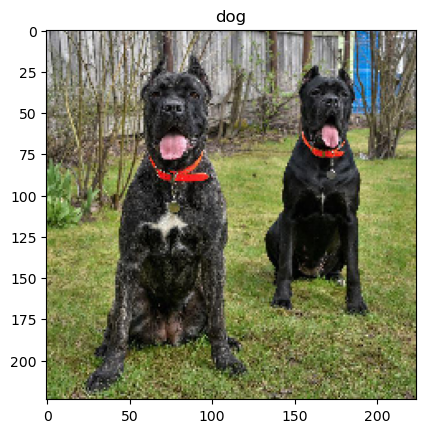

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


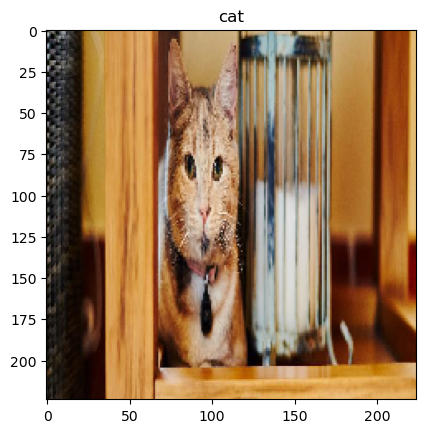

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


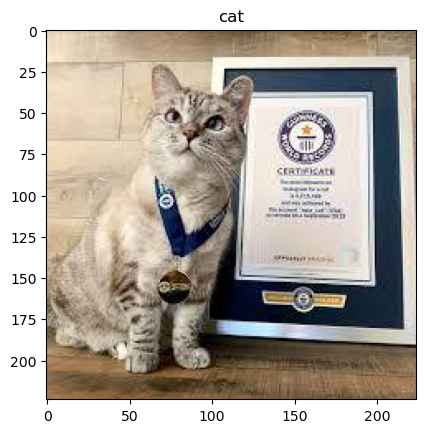

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


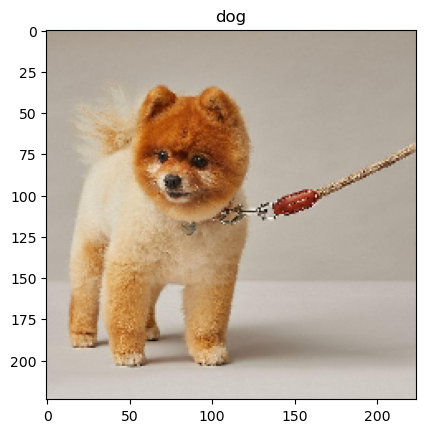

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


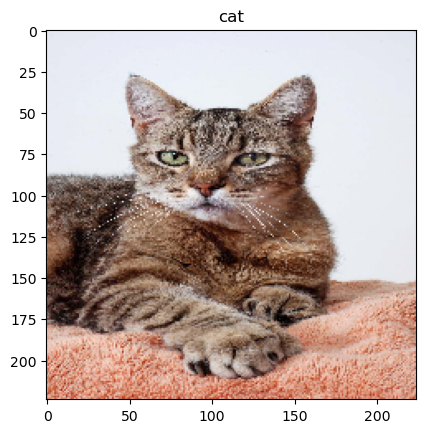

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


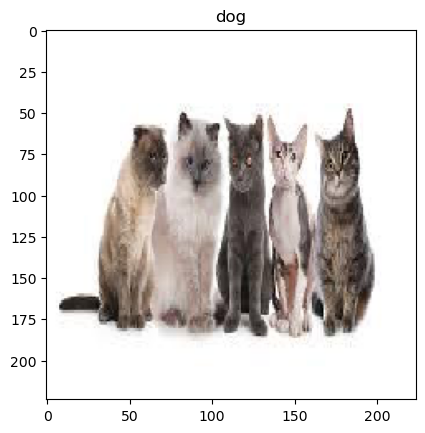

OSError: image file is truncated (2 bytes not processed)

In [48]:
import os  # Импорт модуля os для работы с файловой системой
import random  # Импорт модуля random для работы с случайными числами

categ = ['cat', 'dog']  # Список категорий: 'cat' - кошка, 'dog' - собака
files = []  # Пустой список для хранения путей к изображениям

# Перебор всех файлов в каталоге с кошками и добавление путей в список files
for root, dirs, filenames in os.walk('/Users/nikitamakarov/Documents/321/CatsDogs/test/cats'):
    for filename in filenames:
        files.append(os.path.join(root, filename))

# Перебор всех файлов в каталоге с собаками и добавление путей в список files
for root, dirs, filenames in os.walk('/Users/nikitamakarov/Documents/321/CatsDogs/test/dogs'):
    for filename in filenames:
        files.append(os.path.join(root, filename))

# Выбор случайных 10 изображений из списка files и их отображение с предсказанием модели
for f in random.sample(files, 10):
    img_path = f  # Путь к изображению
    img = image.load_img(img_path, target_size=(224,224))  # Загрузка изображения с изменением размера до 224x224 пикселя
    img_array = image.img_to_array(img)  # Преобразование изображения в массив numpy

    expanded_img_array = np.expand_dims(img_array, axis=0)  # Расширение массива изображения
    preprocessed_img = preprocess_input(expanded_img_array)  # Предварительная обработка изображения
    prediction = model.predict(preprocessed_img)  # Получение предсказания от модели
    
    plt.title(categ[np.argmax(prediction)])  # Установка заголовка графика в соответствии с предсказанием модели
    plt.imshow(img)  # Отображение изображения
    plt.show()  # Показ графика
